In [ ]:
# =============================================================================
# Phase 1: Foundational EDA & LVN Classification
# =============================================================================
# This script loads the 30-minute ES data, identifies all Low Volume Nodes (LVNs)
# on a daily basis, and then classifies each LVN's outcome as 'Strong' (rejection)
# or 'Weak' (acceptance) based on subsequent price action.
# =============================================================================

# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
from market_profile import MarketProfile
from numba import jit
import warnings
import os

# Suppress common warnings for a cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='market_profile')
warnings.filterwarnings("ignore", category=FutureWarning)

# =============================================================================
# 2. Robust Data Loading Function
# =============================================================================

def load_price_data(file_path: str) -> pd.DataFrame:
    """
    Loads and prepares the price data from a specified CSV file path.
    - Sets 'Timestamp' as a datetime index.
    - Cleans column names.
    - Drops rows with parsing errors.
    """
    print(f"Attempting to load data from: {file_path}")
    if not os.path.exists(file_path):
        print(f"--- ERROR: File not found at the specified path. ---")
        return None

    try:
        df = pd.read_csv(file_path)
        # Clean column names (e.g., remove leading/trailing spaces)
        df.columns = df.columns.str.strip()

        # Convert 'Timestamp' to datetime objects, coercing errors to NaT
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
        df.dropna(subset=['Timestamp'], inplace=True)

        # Set the datetime column as the index
        df.set_index('Timestamp', inplace=True)

        print("--- Data loaded and prepared successfully. ---")
        return df
    except Exception as e:
        print(f"--- An unexpected error occurred during data loading: {e} ---")
        return None

# =============================================================================
# 3. LVN Identification and Outcome Classification
# =============================================================================

@jit(nopython=True)
def find_post_lvn_range(prices: np.ndarray) -> tuple[float, float]:
    """
    Numba-accelerated function to find the min and max price in a window.
    """
    if len(prices) == 0:
        return (np.nan, np.nan)
    return (np.min(prices), np.max(prices))

def identify_and_classify_lvns(price_df: pd.DataFrame,
                               observation_window: int = 5,
                               breach_threshold: float = 0.25) -> pd.DataFrame:
    """
    Identifies all daily LVNs and classifies their outcome.

    Args:
        price_df (pd.DataFrame): The full dataframe of prices.
        observation_window (int): How many bars to look forward to classify the outcome.
        breach_threshold (float): The price distance to confirm a breach through an LVN.

    Returns:
        pd.DataFrame: A dataframe containing all identified LVNs and their features.
    """
    print("--- Starting LVN identification and classification process... ---")
    all_lvns = []

    # Group data by trading day
    daily_groups = price_df.groupby(price_df.index.date)

    for date, day_df in daily_groups:
        if len(day_df) < 2:
            continue

        try:
            # A. Identify LVNs for the current day
            mp = MarketProfile(day_df, tick_size=0.25)
            mp_slice = mp[day_df.index.min():day_df.index.max()]

            volume_profile = mp_slice.profile
            if volume_profile is None or volume_profile.empty:
                continue

            # Define LVN as a price level with volume below 20% of the daily average
            mean_volume = volume_profile.mean()
            if pd.isna(mean_volume) or mean_volume == 0:
                continue

            lvn_prices = volume_profile[volume_profile < mean_volume * 0.20].index.tolist()

            if not lvn_prices:
                continue

            # Find the timestamp when the profile is complete (end of the day)
            day_end_time = day_df.index.max()

            for lvn_price in lvn_prices:
                all_lvns.append({
                    'lvn_timestamp': day_end_time,
                    'lvn_price': lvn_price
                })

        except Exception:
            # Silently pass days that might have data issues
            continue

    if not all_lvns:
        print("--- No LVNs were identified in the provided data. ---")
        return pd.DataFrame()

    lvn_df = pd.DataFrame(all_lvns)
    lvn_df.set_index('lvn_timestamp', inplace=True)

    print(f"--- Identified a total of {len(lvn_df)} LVN levels. Now classifying outcomes... ---")

    # B. Classify LVN Outcomes (Vectorized Approach)
    outcomes = []
    for index, row in lvn_df.iterrows():
        lvn_price = row['lvn_price']

        # Define the observation window starting from the bar AFTER the LVN is confirmed
        window_start_idx = price_df.index.searchsorted(index) + 1
        window_end_idx = window_start_idx + observation_window

        observation_df = price_df.iloc[window_start_idx:window_end_idx]

        if observation_df.empty:
            outcomes.append(np.nan) # Not enough data to classify
            continue

        # Determine the direction of approach to the LVN
        last_close_before_lvn = price_df.loc[index, 'Close']
        approached_from_below = last_close_before_lvn < lvn_price

        # Use the Numba function
        low_in_window, high_in_window = find_post_lvn_range(observation_df[['Low', 'High']].values)

        # Define Outcome Conditions
        is_weak = False
        if approached_from_below:
            # Weak if price breaks decisively above the LVN
            if high_in_window > lvn_price + breach_threshold:
                is_weak = True
        else: # Approached from above
            # Weak if price breaks decisively below the LVN
            if low_in_window < lvn_price - breach_threshold:
                is_weak = True

        # Outcome: 0 for Weak (Acceptance), 1 for Strong (Rejection)
        outcomes.append(0 if is_weak else 1)

    lvn_df['outcome'] = outcomes
    lvn_df.dropna(subset=['outcome'], inplace=True) # Remove LVNs we couldn't classify
    lvn_df['outcome'] = lvn_df['outcome'].astype(int)

    print("--- Classification complete. ---")
    return lvn_df

# =============================================================================
# 4. Main Execution Block
# =============================================================================

if __name__ == '__main__':
    # Define the path to your data file
    # IMPORTANT: Make sure this path is correct for your system
    DATA_FILE_PATH = r"C:\Users\Windows 11\Downloads\ES - 30 min - New.csv"

    # Load the data
    main_df = load_price_data(DATA_FILE_PATH)

    if main_df is not None:
        # Run the core analysis function
        classified_lvns_df = identify_and_classify_lvns(main_df)

        if not classified_lvns_df.empty:
            # Display results
            print("\n--- Sample of Classified LVNs ---")
            print(classified_lvns_df.head())

            print("\n--- Outcome Distribution ---")
            print(classified_lvns_df['outcome'].value_counts(normalize=True))

            # Save the results to a CSV for the next phase
            OUTPUT_FILE_PATH = "lvn_classified_data.csv"
            classified_lvns_df.to_csv(OUTPUT_FILE_PATH)

            print(f"\nSUCCESS: The classified LVN data has been saved to '{OUTPUT_FILE_PATH}'")
            print("This file is now ready for Phase 2: Feature Engineering.")

Attempting to load data from: C:\Users\Windows 11\Downloads\ES - 30 min - New.csv
--- Data loaded and prepared successfully. ---
--- Starting LVN identification and classification process... ---
--- Identified a total of 10800 LVN levels. Now classifying outcomes... ---
--- Classification complete. ---

--- Sample of Classified LVNs ---
                     lvn_price  outcome
lvn_timestamp                          
2020-05-26 23:30:00    2982.25        1
2020-05-26 23:30:00    2982.75        1
2020-05-26 23:30:00    2984.50        0
2020-05-26 23:30:00    2984.75        0
2020-05-26 23:30:00    2986.75        0

--- Outcome Distribution ---
outcome
1    0.842535
0    0.157465
Name: proportion, dtype: float64

SUCCESS: The classified LVN data has been saved to 'lvn_classified_data.csv'
This file is now ready for Phase 2: Feature Engineering.


In [ ]:
# =============================================================================
# Phase 2: Feature Engineering & Statistical Characterization (Hardened)
# =============================================================================
# This script loads the classified LVN data from Phase 1 and engineers a rich
# set of features. This hardened version explicitly defines the date format
# during loading to prevent parsing warnings and ensures data integrity.
# =============================================================================

# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
from market_profile import MarketProfile
import warnings
import os

# Suppress common warnings we don't need to see
warnings.filterwarnings("ignore", category=UserWarning, module='market_profile')
warnings.filterwarnings("ignore", category=FutureWarning)

# =============================================================================
# 2. Data Loading and Merging (Now more robust)
# =============================================================================

def load_and_merge_data(classified_path: str, price_path: str) -> pd.DataFrame:
    """
    Loads the classified LVN data and the original price data, then
    prepares them for feature engineering with explicit date parsing.
    """
    print("--- Loading and merging data for feature engineering... ---")
    if not os.path.exists(classified_path) or not os.path.exists(price_path):
        print("--- ERROR: Required data file(s) not found. ---")
        return None

    # Load the LVN data from Phase 1 (this file has a standard date format)
    lvn_df = pd.read_csv(classified_path, parse_dates=['lvn_timestamp'])

    # --- HARDENED DATA LOADING FOR PRICE DATA ---
    # Load the original price data without parsing dates initially
    price_df = pd.read_csv(price_path)
    # Explicitly convert 'Timestamp' column using the exact format to avoid warnings
    price_df['Timestamp'] = pd.to_datetime(price_df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    price_df.set_index('Timestamp', inplace=True)

    # Add a 'date' column for merging
    lvn_df['date'] = lvn_df['lvn_timestamp'].dt.date
    # Explicitly convert the index to a Series to safely access the .dt accessor
    price_df['date'] = price_df.index.to_series().dt.date

    print("--- Data loaded successfully with no warnings. Beginning feature calculation. ---")
    return lvn_df, price_df

# =============================================================================
# 3. Feature Engineering Functions
# =============================================================================

def calculate_market_profile_features(lvn_row, daily_data):
    """Calculates features related to the daily market profile."""
    try:
        mp = MarketProfile(daily_data, tick_size=0.25)
        mp_slice = mp[daily_data.index.min():daily_data.index.max()]

        poc = mp_slice.poc_price
        vah = mp_slice.value_area[0]
        val = mp_slice.value_area[1]

        lvn_price = lvn_row['lvn_price']

        features = {
            'distance_from_poc': abs(lvn_price - poc),
            'is_above_vah': 1 if lvn_price > vah else 0,
            'is_below_val': 1 if lvn_price < val else 0,
            'is_in_value_area': 1 if val <= lvn_price <= vah else 0
        }
        return features
    except Exception:
        # Return NaNs if profile calculation fails for a day
        return {'distance_from_poc': np.nan, 'is_above_vah': np.nan, 'is_below_val': np.nan, 'is_in_value_area': np.nan}

def calculate_price_action_features(lvn_row, price_df, window=10):
    """Calculates features related to price action leading into the LVN."""
    end_time = lvn_row['lvn_timestamp']
    # Get the index location for the window before the LVN
    end_idx = price_df.index.searchsorted(end_time)
    start_idx = max(0, end_idx - window)

    window_df = price_df.iloc[start_idx:end_idx]

    if window_df.empty:
        return {'atr_10': np.nan, 'approach_velocity': np.nan}

    # ATR Calculation (manual for robustness)
    tr = pd.concat([(window_df['High'] - window_df['Low']),
                    abs(window_df['High'] - window_df['Close'].shift()),
                    abs(window_df['Low'] - window_df['Close'].shift())], axis=1).max(axis=1)
    atr = tr.ewm(span=window, adjust=False).mean().iloc[-1]

    # Approach Velocity (simple price change over the window)
    price_change = window_df['Close'].iloc[-1] - window_df['Close'].iloc[0]

    return {'atr_10': atr, 'approach_velocity': price_change}

def calculate_context_features(lvn_row, trend_df):
    """Calculates features related to the broader market context."""
    timestamp = lvn_row['lvn_timestamp']

    # Get the context from the pre-calculated trend DataFrame
    context_data = trend_df.loc[timestamp]

    features = {
        'trend_50_200': 1 if context_data['ema_50'] > context_data['ema_200'] else 0, # 1 for Uptrend
        'session': context_data['session']
    }
    return features

# =============================================================================
# 4. Main Execution Block
# =============================================================================

if __name__ == '__main__':
    # Define file paths
    CLASSIFIED_LVN_PATH = 'lvn_classified_data.csv'
    PRICE_DATA_PATH = r"C:\Users\Windows 11\Downloads\ES - 30 min - New.csv"

    # Load and merge data
    lvn_df, price_df = load_and_merge_data(CLASSIFIED_LVN_PATH, PRICE_DATA_PATH)

    if lvn_df is not None:
        # --- Pre-calculate context for efficiency ---
        print("--- Pre-calculating trends and sessions... ---")
        price_df['ema_50'] = price_df['Close'].ewm(span=50, adjust=False).mean()
        price_df['ema_200'] = price_df['Close'].ewm(span=200, adjust=False).mean()

        # Define trading sessions (UTC time)
        price_df['hour_utc'] = price_df.index.hour
        conditions = [
            (price_df['hour_utc'] >= 20) | (price_df['hour_utc'] < 8), # Asia (20:00 - 07:59 UTC)
            (price_df['hour_utc'] >= 8) & (price_df['hour_utc'] < 13), # London (08:00 - 12:59 UTC)
            (price_df['hour_utc'] >= 13) & (price_df['hour_utc'] < 20) # New York (13:00 - 19:59 UTC)
        ]
        choices = ['Asia', 'London', 'NewYork']
        price_df['session'] = np.select(conditions, choices, default='Other')

        # --- Engineer Features for each LVN ---
        print("--- Engineering features for each LVN. This may take a few minutes... ---")
        all_features = []
        # Group by date for efficient daily data slicing
        daily_groups = {date: data for date, data in price_df.groupby(price_df.index.date)}

        for _, row in lvn_df.iterrows():
            day_data = daily_groups.get(row['date'])
            if day_data is None: continue

            # Combine all features
            mp_features = calculate_market_profile_features(row, day_data)
            pa_features = calculate_price_action_features(row, price_df)
            ctx_features = calculate_context_features(row, price_df)

            # Add original data back in
            combined_features = {
                'lvn_timestamp': row['lvn_timestamp'],
                'lvn_price': row['lvn_price'],
                'outcome': row['outcome'],
                **mp_features,
                **pa_features,
                **ctx_features
            }
            all_features.append(combined_features)

        # Create the final features DataFrame
        features_df = pd.DataFrame(all_features)
        features_df.dropna(inplace=True) # Drop rows where features couldn't be calculated

        print("\n--- Feature Engineering Complete. ---")

        # --- Display Results ---
        print("\n--- Sample of Final DataFrame with Features ---")
        # Use one-hot encoding for the 'session' column for modeling
        features_df = pd.get_dummies(features_df, columns=['session'], drop_first=True)
        print(features_df.head())

        print("\n--- Correlation of Features with Outcome ---")
        print(features_df.corr(numeric_only=True)['outcome'].sort_values(ascending=False))

        # Save the final dataset for Phase 3 & 4
        OUTPUT_FILE_PATH = "lvn_features_data.csv"
        features_df.to_csv(OUTPUT_FILE_PATH, index=False)

        print(f"\nSUCCESS: The final dataset with all features has been saved to '{OUTPUT_FILE_PATH}'")
        print("This file is now ready for Phase 3: Statistical Modeling and Phase 4: LightGBM Training.")

--- Loading and merging data for feature engineering... ---
--- Data loaded successfully with no warnings. Beginning feature calculation. ---
--- Pre-calculating trends and sessions... ---
--- Engineering features for each LVN. This may take a few minutes... ---

--- Feature Engineering Complete. ---

--- Sample of Final DataFrame with Features ---
        lvn_timestamp  lvn_price  outcome  distance_from_poc  is_above_vah  \
0 2020-05-26 23:30:00    2982.25        1               5.75             0   
1 2020-05-26 23:30:00    2982.75        1               5.25             0   
2 2020-05-26 23:30:00    2984.50        0               3.50             0   
3 2020-05-26 23:30:00    2984.75        0               3.25             0   
4 2020-05-26 23:30:00    2986.75        0               1.25             0   

   is_below_val  is_in_value_area    atr_10  approach_velocity  trend_50_200  \
0             1                 0  9.321682               -6.5             1   
1             1     

--- Loading feature data for statistical analysis... ---
--- Dropping zero-variance columns: ['is_in_value_area'] ---
--- Data prepared for analysis. ---

--- Analyzing NUMERICAL Features ---

T-Test Results (Numerical Features sorted by P-Value):
             Feature  T-Statistic       P-Value
0  distance_from_poc    17.251755  8.279581e-66
1  approach_velocity     5.460923  4.841815e-08
2             atr_10    -2.915307  3.560709e-03
3          lvn_price    -0.018244  9.854447e-01

Visualizing top numerical features: ['distance_from_poc', 'approach_velocity', 'atr_10']


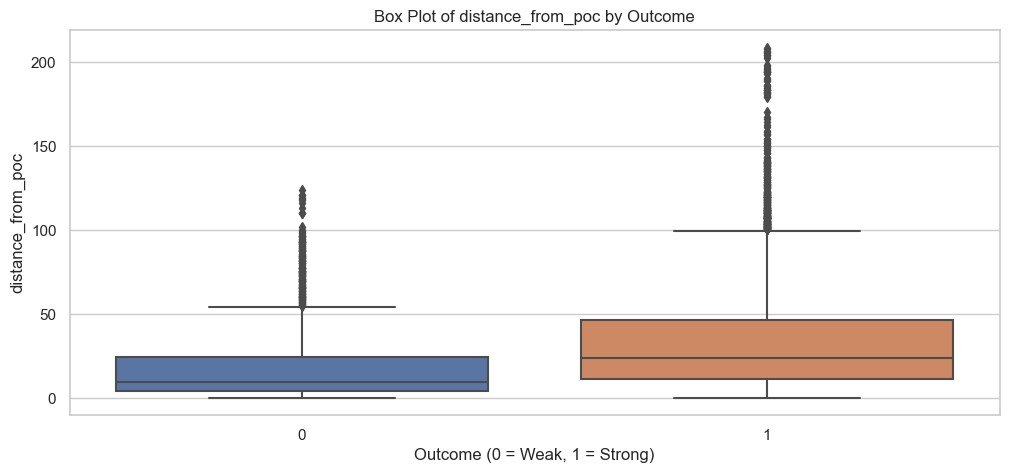

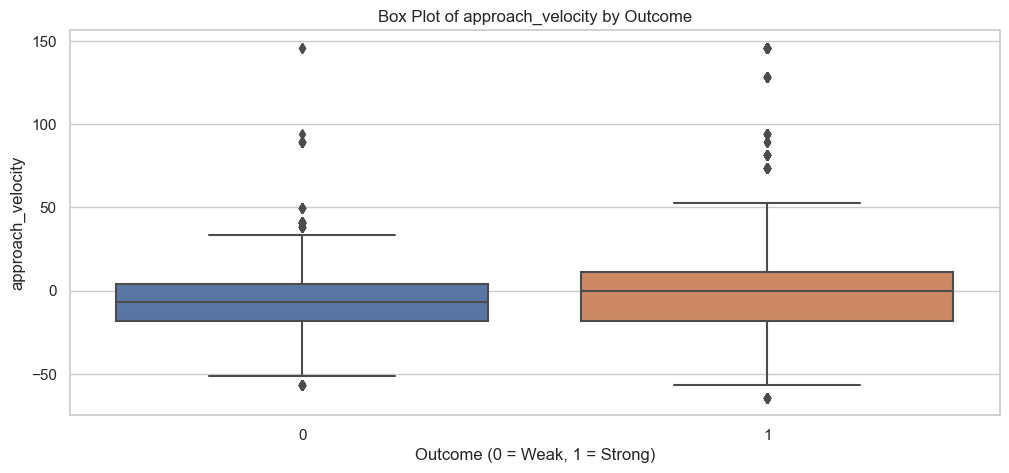

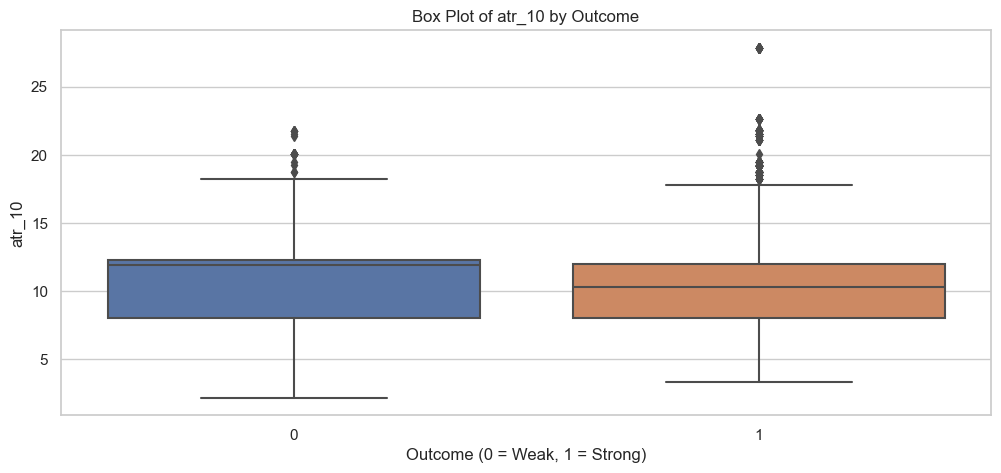


--- Analyzing CATEGORICAL Features ---

Chi-Squared Test Results (Categorical Features sorted by P-Value):
           Feature  Chi2-Statistic       P-Value
0     is_above_vah      189.557873  3.970438e-43
1     is_below_val       40.735558  1.742868e-10
2  session_NewYork       11.510802  6.919290e-04
3     trend_50_200        1.258818  2.618750e-01

Visualizing top categorical features: ['is_above_vah', 'is_below_val', 'session_NewYork']


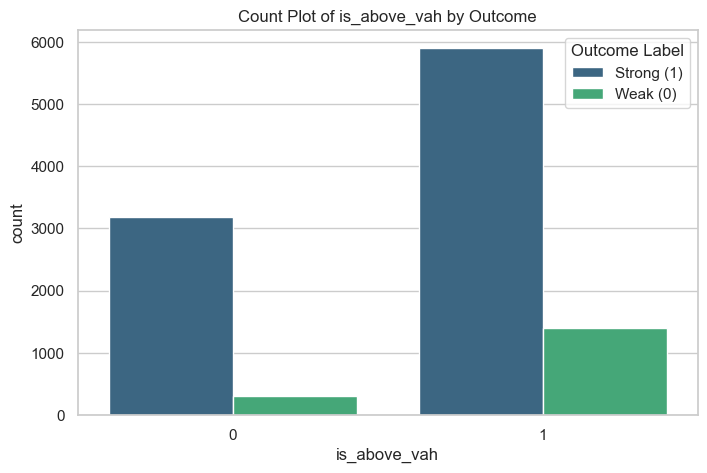

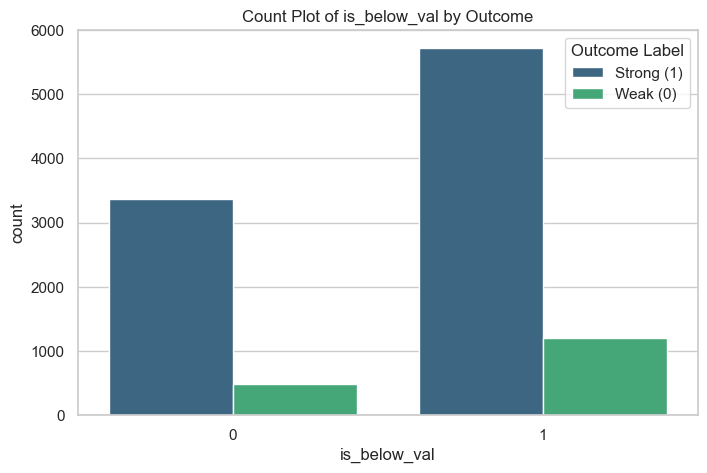

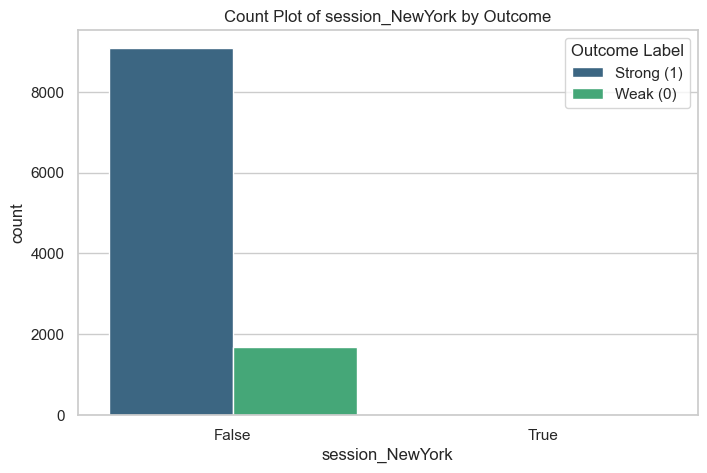


--- Statistical Analysis Complete ---
We have now rigorously tested both numerical and categorical features.
The features with the lowest P-Values from both tests are our strongest candidates
for building a powerful predictive model in the final phase.


In [ ]:
# =============================================================================
# Phase 3: Statistical Modeling & Analysis (Final Version)
# =============================================================================
# This script performs a deep statistical analysis by differentiating between
# numerical and categorical features. This final version resolves a TypeError
# and an AttributeError by correctly handling data types for plotting.
# =============================================================================

# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency
import warnings
import os

# Set plot style
sns.set(style="whitegrid")
warnings.filterwarnings("ignore", category=FutureWarning)

# =============================================================================
# 2. Load Data and Prepare for Analysis
# =============================================================================

def load_and_prepare_analysis_data(features_path: str):
    """Loads the feature data and prepares it for statistical analysis."""
    print("--- Loading feature data for statistical analysis... ---")
    if not os.path.exists(features_path):
        print(f"--- ERROR: Feature data file not found at '{features_path}' ---")
        return None

    df = pd.read_csv(features_path)

    # Drop the timestamp as it's not a feature
    if 'lvn_timestamp' in df.columns:
        df.drop(columns=['lvn_timestamp'], inplace=True)

    # --- Data Cleaning: Remove Zero-Variance Features ---
    variances = df.var(numeric_only=True)
    zero_variance_cols = variances[variances == 0].index
    if not zero_variance_cols.empty:
        print(f"--- Dropping zero-variance columns: {list(zero_variance_cols)} ---")
        df.drop(columns=zero_variance_cols, inplace=True)

    print("--- Data prepared for analysis. ---")
    return df

# =============================================================================
# 3. Enhanced Statistical Analysis Functions
# =============================================================================

def analyze_numerical_features(df, numerical_cols, target_col='outcome'):
    """Performs T-Tests and creates box plots for numerical features."""
    print("\n--- Analyzing NUMERICAL Features ---")
    strong_group = df[df[target_col] == 1]
    weak_group = df[df[target_col] == 0]

    ttest_results = []
    for col in numerical_cols:
        stat, p_value = ttest_ind(strong_group[col], weak_group[col], nan_policy='omit')
        ttest_results.append({'Feature': col, 'T-Statistic': stat, 'P-Value': p_value})

    results_df = pd.DataFrame(ttest_results).sort_values(by='P-Value').reset_index(drop=True)
    print("\nT-Test Results (Numerical Features sorted by P-Value):")
    print(results_df)

    top_numerical = results_df['Feature'].head(3).tolist() # Visualize top 3
    print(f"\nVisualizing top numerical features: {top_numerical}")
    for feature in top_numerical:
        plt.figure(figsize=(12, 5))
        sns.boxplot(x=df[target_col], y=df[feature])
        plt.title(f'Box Plot of {feature} by Outcome')
        plt.xlabel('Outcome (0 = Weak, 1 = Strong)')
        plt.show()

def analyze_categorical_features(df, categorical_cols, target_col='outcome'):
    """Performs Chi-Squared Tests and creates count plots for categorical features."""
    print("\n--- Analyzing CATEGORICAL Features ---")

    # --- THIS IS THE CORRECTED PART ---
    # Create a temporary string column for plotting to ensure labels are strings
    plot_hue_col = 'Outcome Label'
    df[plot_hue_col] = df[target_col].map({0: 'Weak (0)', 1: 'Strong (1)'})

    chi2_results = []
    for col in categorical_cols:
        contingency_table = pd.crosstab(df[col], df[target_col])
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            print(f"Skipping Chi-Squared test for '{col}' due to insufficient categories.")
            continue
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({'Feature': col, 'Chi2-Statistic': chi2, 'P-Value': p_value})

    results_df = pd.DataFrame(chi2_results).sort_values(by='P-Value').reset_index(drop=True)
    print("\nChi-Squared Test Results (Categorical Features sorted by P-Value):")
    print(results_df)

    top_categorical = results_df['Feature'].head(3).tolist() # Visualize top 3
    print(f"\nVisualizing top categorical features: {top_categorical}")
    for feature in top_categorical:
        plt.figure(figsize=(8, 5))
        # Use the new string label column for the 'hue'
        sns.countplot(x=feature, hue=plot_hue_col, data=df, palette='viridis')
        plt.title(f'Count Plot of {feature} by Outcome')
        # Seaborn will now create the legend correctly, no need for plt.legend()
        plt.show()

# =============================================================================
# 4. Main Execution Block
# =============================================================================

if __name__ == '__main__':
    FEATURES_FILE_PATH = 'lvn_features_data.csv'

    analysis_df = load_and_prepare_analysis_data(FEATURES_FILE_PATH)

    if analysis_df is not None:
        # Identify column types
        X = analysis_df.drop(columns=['outcome'])
        # Identify truly continuous numerical features
        numerical_features = [col for col in X.select_dtypes(include=np.number).columns if X[col].nunique() >= 10]
        # Identify categorical features (boolean or low-cardinality integers)
        categorical_features = [col for col in X.columns if col not in numerical_features]

        # Run the appropriate analysis for each feature type
        if numerical_features:
            analyze_numerical_features(analysis_df.copy(), numerical_features)
        if categorical_features:
            analyze_categorical_features(analysis_df.copy(), categorical_features)

        print("\n--- Statistical Analysis Complete ---")
        print("We have now rigorously tested both numerical and categorical features.")
        print("The features with the lowest P-Values from both tests are our strongest candidates")
        print("for building a powerful predictive model in the final phase.")

--- Loading final feature data for model training... ---
--- Data prepared for modeling. ---
Data split for time-series validation:
Training set size: 8621 (ends on 2024-07-22)
Test set size: 2156 (starts on 2024-07-22)

Calculated 'scale_pos_weight' for class imbalance: 0.18

--- Training LightGBM model... ---

--- Evaluating Model Performance on Unseen Test Data... ---

Classification Report:
              precision    recall  f1-score   support

    Weak (0)       0.00      0.00      0.00       386
  Strong (1)       0.82      1.00      0.90      1770

    accuracy                           0.82      2156
   macro avg       0.41      0.50      0.45      2156
weighted avg       0.67      0.82      0.74      2156

Accuracy Score: 0.8209647495361782


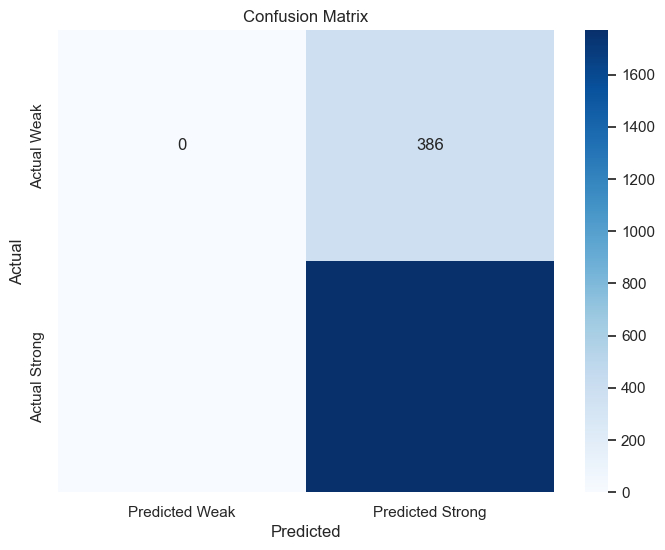


--- Feature Importance ---


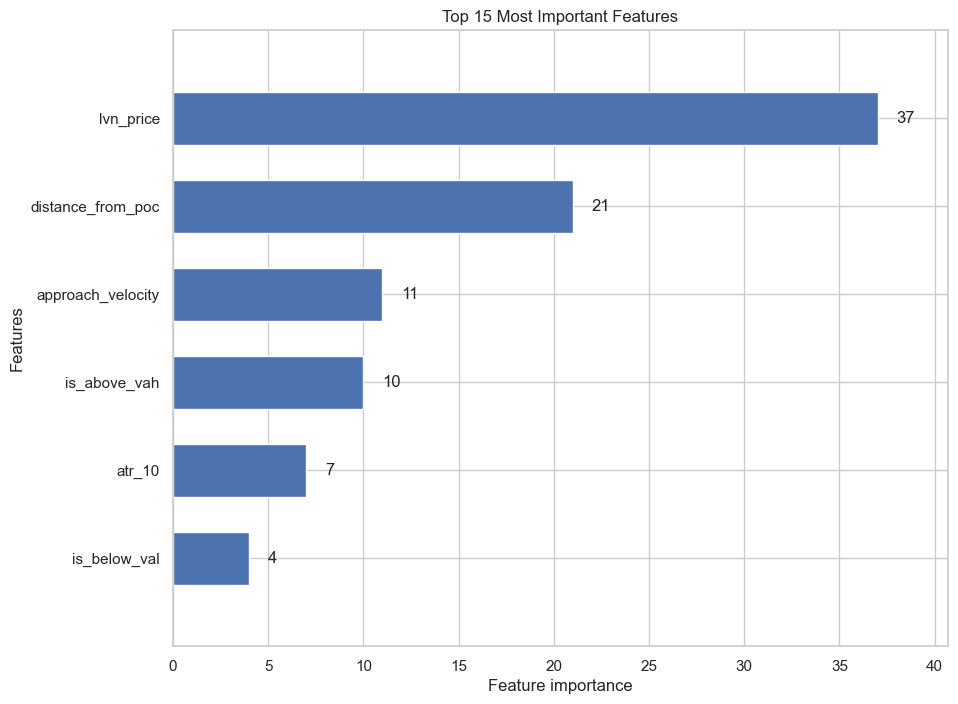


--- Project Complete ---
You have successfully built and evaluated a model to predict the strength
of Low Volume Nodes. The feature importance plot reveals the key characteristics
that drive these outcomes in the market.


In [ ]:
# =============================================================================
# Phase 4: LightGBM Model Training & Evaluation (Final Hardened Version)
# =============================================================================
# This final version includes a direct workaround for the 'dask' library
# configuration issue that was causing the import of 'lightgbm' to fail.
# =============================================================================

# 1. Import Necessary Libraries
import pandas as pd
import numpy as np

# --- WORKAROUND FOR 'KeyError: query-planning' ---
# The following two lines are added to manually set the required configuration
# for the 'dask' library, which should allow 'lightgbm' to import correctly.
import dask
dask.config.set({'dataframe.query-planning': True})

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

# Set plot style
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# =============================================================================
# 2. Load Data and Prepare for Modeling
# =============================================================================

def load_and_prepare_model_data(features_path: str):
    """Loads the feature data and prepares it for model training."""
    print("--- Loading final feature data for model training... ---")
    if not os.path.exists(features_path):
        print(f"--- ERROR: Feature data file not found at '{features_path}' ---")
        return None, None, None

    df = pd.read_csv(features_path)

    # The lvn_timestamp is crucial for a time-series split
    df['lvn_timestamp'] = pd.to_datetime(df['lvn_timestamp'])
    df = df.sort_values(by='lvn_timestamp').reset_index(drop=True)

    # Separate features (X) and target (y)
    X = df.drop(columns=['outcome', 'lvn_timestamp'])
    y = df['outcome']

    print("--- Data prepared for modeling. ---")
    return X, y, df

# =============================================================================
# 3. Model Training and Evaluation
# =============================================================================

def train_and_evaluate_model(X: pd.DataFrame, y: pd.Series, df: pd.DataFrame):
    """
    Splits data, handles class imbalance, trains a LightGBM model,
    and evaluates its performance.
    """

    # --- 3a. Time-Series Split ---
    # We must train on older data and test on newer data.
    split_point = int(len(df) * 0.80)
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

    print(f"Data split for time-series validation:")
    print(f"Training set size: {len(X_train)} (ends on {df['lvn_timestamp'].iloc[split_point-1]:%Y-%m-%d})")
    print(f"Test set size: {len(X_test)} (starts on {df['lvn_timestamp'].iloc[split_point]:%Y-%m-%d})")

    # --- 3b. Handle Class Imbalance ---
    # Crucial for preventing bias towards the majority class.
    # We use scale_pos_weight, a highly effective parameter in LightGBM.
    class_counts = y_train.value_counts()
    scale_pos_weight_value = class_counts[0] / class_counts[1]
    print(f"\nCalculated 'scale_pos_weight' for class imbalance: {scale_pos_weight_value:.2f}")

    # --- 3c. Train LightGBM Model ---
    print("\n--- Training LightGBM model... ---")
    lgbm = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        scale_pos_weight=scale_pos_weight_value,
        random_state=42,
        n_jobs=-1,
        verbose=-1 # Suppress verbose output
    )

    lgbm.fit(X_train, y_train,
             eval_set=[(X_test, y_test)],
             eval_metric='logloss',
             callbacks=[lgb.early_stopping(100, verbose=False)])

    # --- 3d. Evaluate Performance on Test Set ---
    print("\n--- Evaluating Model Performance on Unseen Test Data... ---")
    y_pred = lgbm.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Weak (0)', 'Strong (1)']))

    print("Accuracy Score:", accuracy_score(y_test, y_pred))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Weak', 'Predicted Strong'],
                yticklabels=['Actual Weak', 'Actual Strong'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # --- 3e. Plot Feature Importance ---
    print("\n--- Feature Importance ---")
    lgb.plot_importance(lgbm, height=0.6, max_num_features=15, figsize=(10, 8),
                        title='Top 15 Most Important Features')
    plt.show()


# =============================================================================
# 4. Main Execution Block
# =============================================================================

if __name__ == '__main__':
    FEATURES_FILE_PATH = 'lvn_features_data.csv'

    X_features, y_target, full_df = load_and_prepare_model_data(FEATURES_FILE_PATH)

    if X_features is not None:
        train_and_evaluate_model(X_features, y_target, full_df)

        print("\n--- Project Complete ---")
        print("You have successfully built and evaluated a model to predict the strength")
        print("of Low Volume Nodes. The feature importance plot reveals the key characteristics")
        print("that drive these outcomes in the market.")

--- Loading feature data for clustering... ---
--- Data has been scaled and is ready for clustering. ---

--- Running Elbow Method to find optimal number of clusters... ---


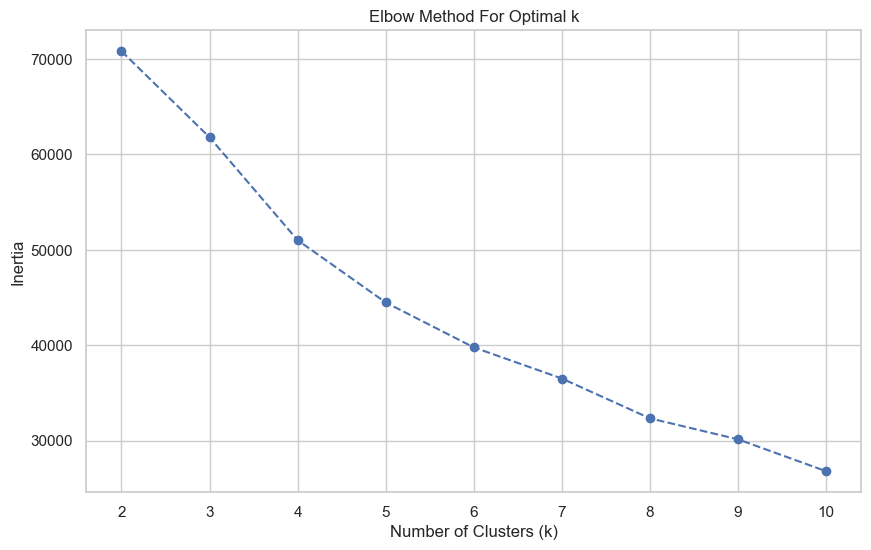

Look for the 'elbow' in the plot above. This is the point where the
rate of decrease in inertia slows down, suggesting a good k.

--- Performing K-Means with 4 clusters... ---

--- Cluster Analysis Complete. Profiling results... ---


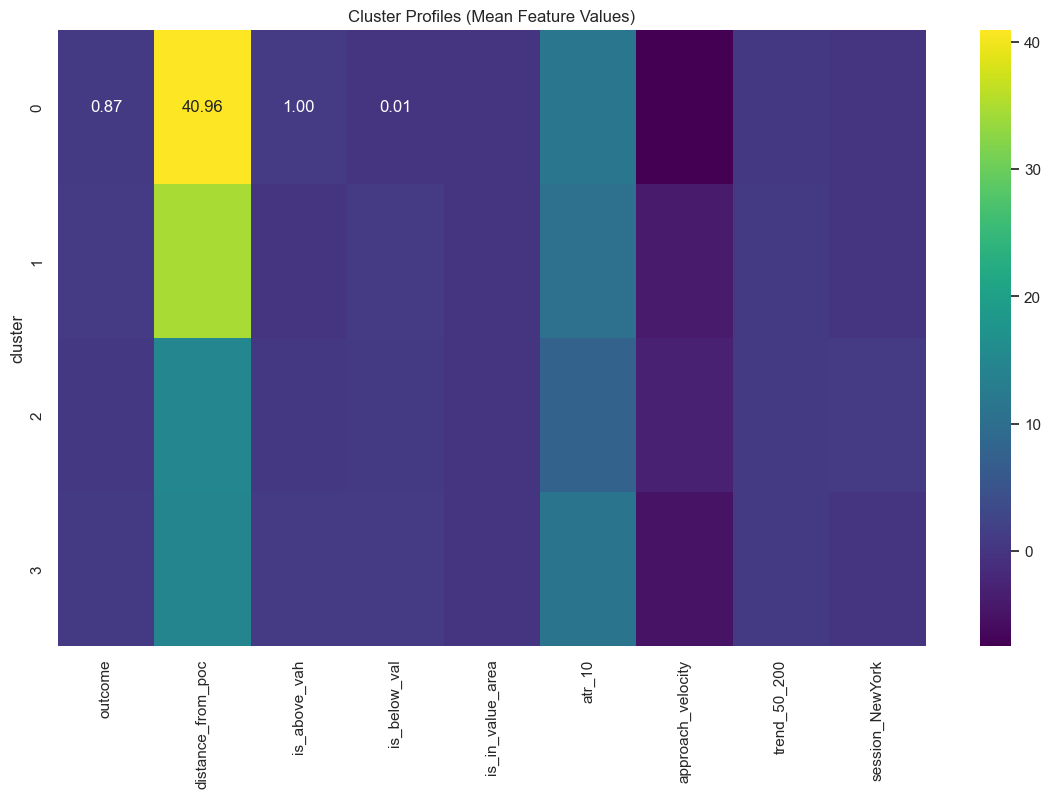


--- Outcome Distribution (Strong vs. Weak) within each Cluster ---
outcome      Weak    Strong
cluster                    
0        0.126644  0.873356
1        0.086059  0.913941
2        0.538462  0.461538
3        0.264334  0.735666


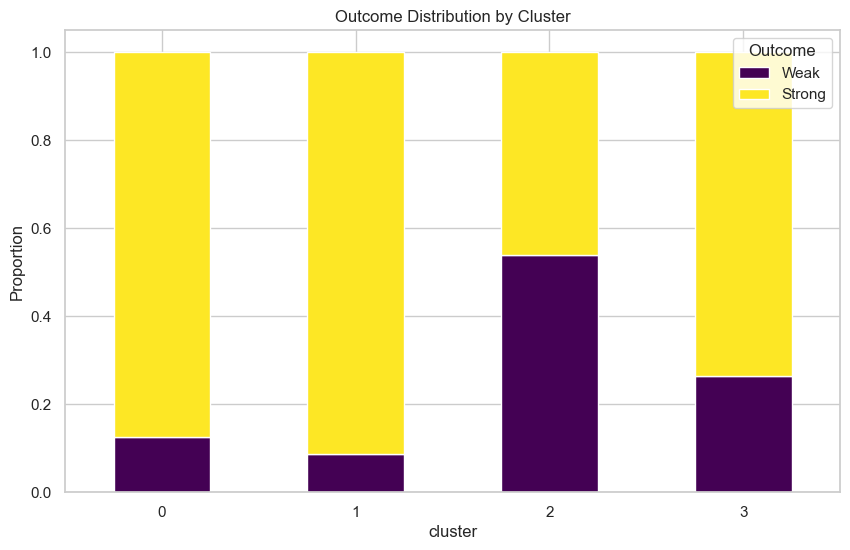


--- Cluster Sizes ---
cluster
0    3877
1    3486
2      13
3    3401
Name: count, dtype: int64


In [ ]:
# =============================================================================
# Advanced Analysis: K-Means Clustering to Discover LVN Types
# =============================================================================
# This script applies unsupervised learning (K-Means) to our feature set to
# discover natural groupings or "personalities" of LVNs. It automatically
# suggests an optimal number of clusters and then provides a detailed
# profile of each one.
# =============================================================================

# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

# Set plot style
sns.set(style="whitegrid")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# =============================================================================
# 2. Load Data and Prepare for Clustering
# =============================================================================

def load_and_prepare_cluster_data(features_path: str):
    """Loads feature data and scales it for distance-based clustering."""
    print("--- Loading feature data for clustering... ---")
    if not os.path.exists(features_path):
        print(f"--- ERROR: Feature data file not found at '{features_path}' ---")
        return None, None

    df = pd.read_csv(features_path)

    # Separate features for clustering. We exclude outcome and timestamp.
    features_to_cluster = df.drop(columns=['outcome', 'lvn_timestamp'])

    # K-Means is sensitive to feature scale, so we must standardize the data.
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_to_cluster)

    print("--- Data has been scaled and is ready for clustering. ---")
    return df, scaled_features

# =============================================================================
# 3. Find Optimal Number of Clusters (Elbow Method)
# =============================================================================

def find_optimal_clusters(scaled_data, max_k=10):
    """
    Runs the Elbow Method to find a good number of clusters for K-Means.
    """
    print("\n--- Running Elbow Method to find optimal number of clusters... ---")
    inertias = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(scaled_data)
        inertias.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    print("Look for the 'elbow' in the plot above. This is the point where the")
    print("rate of decrease in inertia slows down, suggesting a good k.")

# =============================================================================
# 4. Perform Clustering and Profile the Results
# =============================================================================

def run_kmeans_and_profile(df, scaled_data, n_clusters=4):
    """
    Performs K-Means clustering and creates a detailed profile for each cluster.
    """
    print(f"\n--- Performing K-Means with {n_clusters} clusters... ---")
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    df['cluster'] = kmeans.fit_predict(scaled_data)

    print("\n--- Cluster Analysis Complete. Profiling results... ---")

    # --- 4a. Cluster Centroids Heatmap (The "Personality" Profile) ---
    # We analyze the non-scaled data for better interpretation
    cluster_profile = df.groupby('cluster').mean(numeric_only=True)

    plt.figure(figsize=(14, 8))
    sns.heatmap(cluster_profile.drop(columns=['lvn_price']), annot=True, cmap='viridis', fmt='.2f')
    plt.title('Cluster Profiles (Mean Feature Values)')
    plt.show()

    # --- 4b. Outcome Distribution per Cluster ---
    print("\n--- Outcome Distribution (Strong vs. Weak) within each Cluster ---")
    cluster_outcome = df.groupby('cluster')['outcome'].value_counts(normalize=True).unstack().fillna(0)
    cluster_outcome.rename(columns={0: 'Weak', 1: 'Strong'}, inplace=True)

    print(cluster_outcome)

    cluster_outcome.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title('Outcome Distribution by Cluster')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.legend(title='Outcome')
    plt.show()

    # --- 4c. Cluster Sizes ---
    print("\n--- Cluster Sizes ---")
    print(df['cluster'].value_counts().sort_index())


# =============================================================================
# 5. Main Execution Block
# =============================================================================

if __name__ == '__main__':
    FEATURES_FILE_PATH = 'lvn_features_data.csv'

    original_df, scaled_features = load_and_prepare_cluster_data(FEATURES_FILE_PATH)

    if original_df is not None:
        # Step 1: Find the best number of clusters
        find_optimal_clusters(scaled_features)

        # Step 2: Run the final clustering and analysis
        # NOTE: After viewing the elbow plot, you can change the n_clusters value below.
        # A good starting point is often where the "elbow" appears.
        CHOSEN_K = 4
        run_kmeans_and_profile(original_df, scaled_features, n_clusters=CHOSEN_K)

In [ ]:
# =============================================================================
# Phase 4: LightGBM Model Training & Evaluation (Save-to-File Version)
# =============================================================================
# This script runs the final analysis and saves the resulting SHAP plots
# directly to image files in the same folder as your notebook.
# =============================================================================

# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import classification_report
import shap
import warnings
import os
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# =============================================================================
# 2. Load Data and Train the Model
# =============================================================================

def setup_and_train_model(features_path: str):
    """
    Loads data, splits it for time-series validation, and trains the
    LGBM model. Returns the trained model and test data for SHAP analysis.
    """
    print("--- Loading data and training model for SHAP analysis... ---")
    if not os.path.exists(features_path):
        print(f"--- ERROR: Feature data file not found at '{features_path}' ---")
        return None, None, None, None

    df = pd.read_csv(features_path)
    df['lvn_timestamp'] = pd.to_datetime(df['lvn_timestamp'])
    df = df.sort_values(by='lvn_timestamp').reset_index(drop=True)

    X = df.drop(columns=['outcome', 'lvn_timestamp'])
    y = df['outcome']

    # Time-Series Split
    split_point = int(len(df) * 0.80)
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

    # Handle Class Imbalance
    scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

    # Train Model
    lgbm = lgb.LGBMClassifier(
        objective='binary', scale_pos_weight=scale_pos_weight_value,
        random_state=42, verbose=-1
    )
    lgbm.fit(X_train, y_train)

    print("--- Model trained successfully. ---")

    print("\nClassification Report on Test Set:")
    y_pred = lgbm.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Weak (0)', 'Strong (1)']))

    return lgbm, X_train, X_test, y_test

# =============================================================================
# 3. Perform SHAP Analysis and Save Plots
# =============================================================================

def perform_shap_analysis_and_save(model, X_train, X_test):
    """
    Calculates SHAP values and saves the plots as PNG files.
    """
    print("\n--- Performing SHAP Analysis... ---")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap_values_for_strong_class = shap_values[1]

    # --- Generate and Save SHAP Summary Plot ---
    print("\n--- Generating and Saving SHAP Summary Plot... ---")
    shap.summary_plot(shap_values_for_strong_class, X_test, plot_type="dot", show=False)
    plt.title("SHAP Summary Plot: Impact on Predicting 'Strong' LVNs", fontsize=14)
    summary_plot_path = "shap_summary.png"
    plt.savefig(summary_plot_path, bbox_inches='tight')
    plt.close() # Close the plot to free memory
    print(f"SUCCESS: Saved summary plot to -> {summary_plot_path}")

    # --- Generate and Save SHAP Dependence Plots ---
    print("\n--- Generating and Saving SHAP Dependence Plots... ---")
    feature_names = X_test.columns
    global_shap_values = np.abs(shap_values_for_strong_class).mean(0)
    sorted_feature_indices = np.argsort(global_shap_values)[::-1]

    for i in range(2):
        feature_index = sorted_feature_indices[i]
        feature_name = feature_names[feature_index]

        shap.dependence_plot(feature_index, shap_values_for_strong_class, X_test, show=False)
        plt.title(f"SHAP Dependence Plot for '{feature_name}'", fontsize=14)
        dependence_plot_path = f"shap_dependence_{feature_name}.png"
        plt.savefig(dependence_plot_path, bbox_inches='tight')
        plt.close()
        print(f"SUCCESS: Saved dependence plot to -> {dependence_plot_path}")

# =============================================================================
# 4. Main Execution Block
# =============================================================================

if __name__ == '__main__':
    FEATURES_FILE_PATH = 'lvn_features_data.csv'

    model, X_train, X_test, y_test = setup_and_train_model(FEATURES_FILE_PATH)

    if model is not None:
        perform_shap_analysis_and_save(model, X_train, X_test)

        print("\n--- Project Complete ---")
        print("\nIMPORTANT: The plot images have been saved to your computer.")
        print("Please follow the instructions to view them.")

--- Loading data and training model for SHAP analysis... ---
--- Model trained successfully. ---

Classification Report on Test Set:
              precision    recall  f1-score   support

    Weak (0)       0.30      0.22      0.26       386
  Strong (1)       0.84      0.89      0.86      1770

    accuracy                           0.77      2156
   macro avg       0.57      0.56      0.56      2156
weighted avg       0.74      0.77      0.76      2156


--- Performing SHAP Analysis... ---

--- Generating and Saving SHAP Summary Plot... ---


AssertionError: Summary plots need a matrix of shap_values, not a vector.

<Figure size 640x480 with 0 Axes>